# Project 5 - Vehicle Detection

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

from scipy.ndimage.measurements import label

## Initialize list of functions to be used inside the project

### HOG features and visualization

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### Binned color features  

In [3]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

### Color histogram features 

In [4]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Compute features of a single image

In [5]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Define an empty list to receive features
    img_features = []
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Append features to list
        img_features.append(spatial_features)
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Append features to list
        img_features.append(hist_features)
    # Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)

    return np.concatenate(img_features)

### Extract features from a list of images

In [6]:
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        file_features = single_img_features(image, color_space=color_space, spatial_size=spatial_size, 
                                            hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                            cell_per_block=cell_per_block, hog_channel=hog_channel,
                                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        features.append(file_features)
    # Return list of feature vectors
    return features

### Window Slide function - returns list of windows to search inside an image

In [7]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

### Define function to search for car inside each window

In [8]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

### Define a function to draw bounding boxes

In [9]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Find Cars function

In [10]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    mpimg.imsave('./output_images/find_cars.png', img_tosearch, format='png')
    
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    final_window = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_features = X_scaler.transform(hog_features.reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                final_window.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return final_window

### Heat threshold to an image to filter false positives

In [11]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Classifier Training

### Read in cars and notcars

In [12]:
# Read in cars and notcars
cars = glob.glob('./training_data/vehicles/*/*.png')
notcars = glob.glob('./training_data/non-vehicles/*/*.png')

print (len(cars), len(notcars))

8792 8968


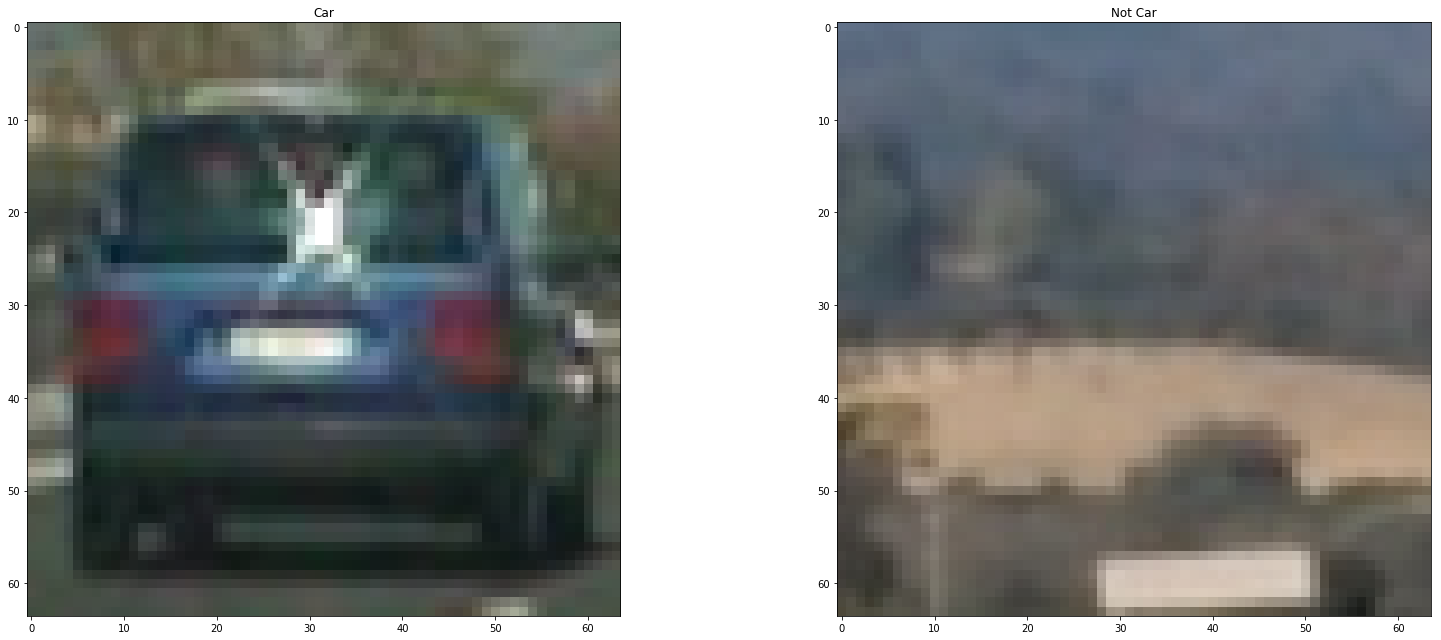

In [13]:
car_img = mpimg.imread(cars[200])
non_car_img = mpimg.imread(notcars[200])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(car_img)
ax1.set_title('Car')
ax2.imshow(non_car_img)
ax2.set_title('Not Car')
fig.tight_layout()
plt.savefig("./output_images/test_images_plot.png")
plt.show()

### Global parameters

In [33]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16 # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
xy_window = (96,96)
xy_overlap = (0.5, 0.5)
scales = [1,1.5,2,2.5]

### Training the classifier

Steps:
1. Extract features for cars and not cars
2. Apply StandardScaler to features
3. Define labels vectors with '1's for cars and '0's for non-cars
4. Split data into training and testing - 20% for testing
5. Use a Linear SVM Classifier to train data and apply GridSearchCV() to obtain the best 'C' value
6. Print Accuracy

In [15]:
car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size, 
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size, 
                                   hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use GridSearchCV() to tune the 'C' parameter on a LinearSVC()
from sklearn import svm
from sklearn.model_selection import GridSearchCV

parameters = {'C':[1, 10]}
# Use a linear SVC 
svr = LinearSVC()
svc = GridSearchCV(svr, parameters)

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

print('Best Parameters chosen = ', svc.best_params_)

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
61.27 Seconds to train SVC...
Test Accuracy of SVC =  0.9778
Best Parameters chosen =  {'C': 1}


In [30]:
# Save model
import pickle

filename = 'finalized_model.sav'
pickle.dump(svc, open(filename, 'wb'))

In [31]:
loaded_svc = pickle.load(open('finalized_model.sav', 'rb'))
print(loaded_svc)

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1, param_grid={'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)


### Hog Image

Color space YCrCb

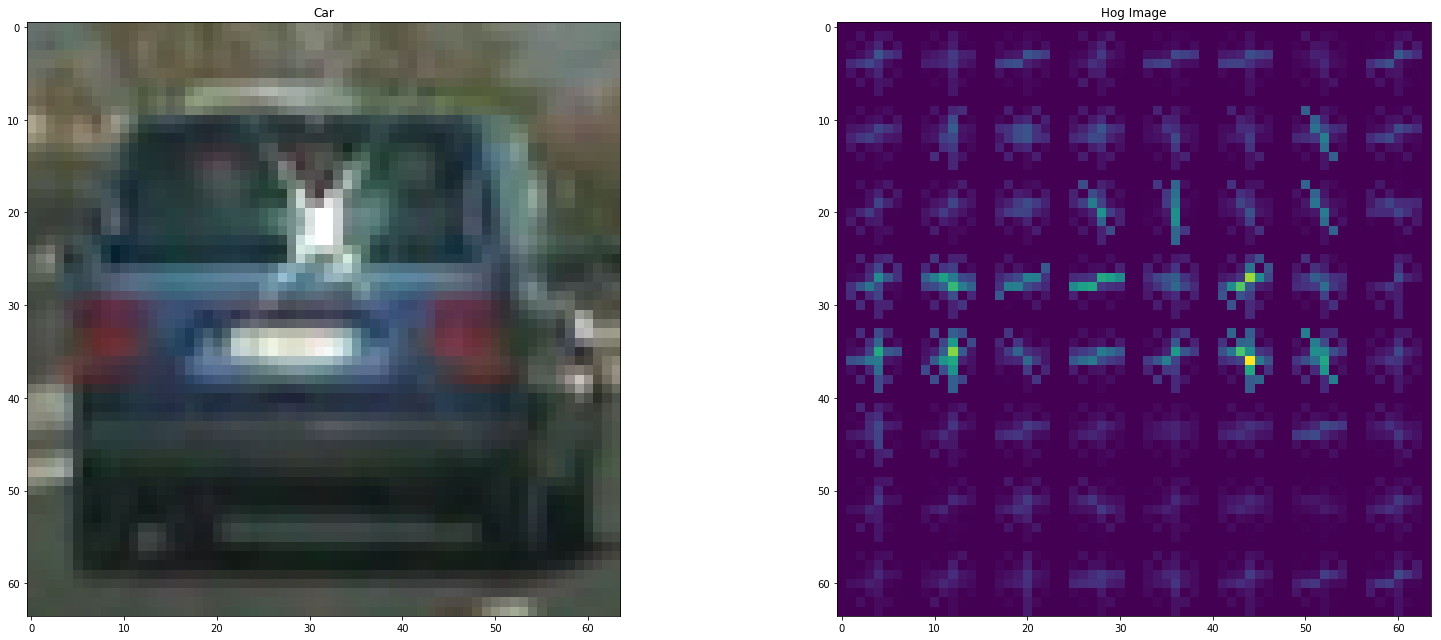

In [16]:
feature_car_image = cv2.cvtColor(car_img, cv2.COLOR_RGB2YCrCb)

features, hog_image = hog(feature_car_image[:,:,1], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False)

plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(car_img)
ax1.set_title('Car')
ax2.imshow(hog_image)
ax2.set_title('Hog Image')
fig.tight_layout()
plt.savefig("./output_images/hog_image_plot.png")
plt.show()

## Pipeline

### Test pipeline for a single image

In [17]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

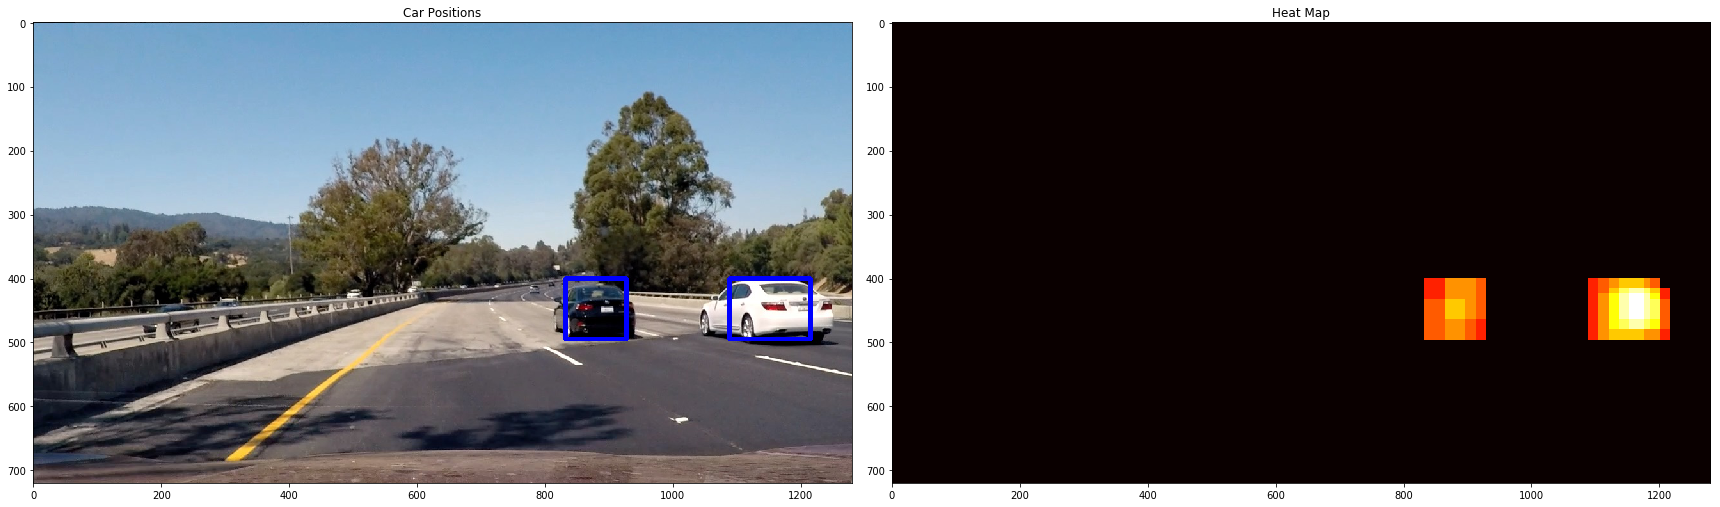

In [88]:
image = mpimg.imread('./test_images/test4.jpg')
draw_image = np.copy(image)
draw_image_windows = np.copy(image)

image = image.astype(np.float32)/255

# Load saved model
loaded_svc = pickle.load(open('finalized_model.sav', 'rb'))

# Find cars using multiple scales
find_car_windows = []
for scale in scales:
    find_car_windows.extend(find_cars(image, y_start_stop[0], y_start_stop[1], scale, loaded_svc, X_scaler, 
                                orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

find_car_img = draw_boxes(draw_image, find_car_windows, color=(0, 0, 255), thick=3)

#Add Heat
heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)
heat = add_heat(heat, find_car_windows)
heat = apply_threshold(heat,4)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_image = draw_labeled_bboxes(draw_image, labels)

#plt.imshow(window_img)
#plt.show()

plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(draw_image)
ax1.set_title('Car Positions')
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map')
fig.tight_layout()
plt.savefig("./output_images/test4_plot.png")
plt.show()

mpimg.imsave('./output_images/test4_result.png', draw_image, format='png')

### Define pipleline for video

In [89]:
from collections import deque

hot_windows_queue = deque([])
hot_windows_set_count = deque([])
counter = 0

def process_image(image):
    global hot_windows_queue, hot_windows_set_count, counter
    counter+=1
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255

    hot_windows = []
    for scale in scales:
        hot_windows.extend(find_cars(image, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, 
                                    orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    # Implement a queue to take the list of last 6 frames' hot_windows and get an average window
    hot_windows_set_count.append(len(hot_windows))
    hot_windows_queue.extend(hot_windows)
    if counter > 6:
        # remove the set of hot_windows that were added first (FIFO model)
        win_count = hot_windows_set_count.popleft()
        for win in range(win_count):
            hot_windows_queue.popleft()
        
    # Add Heat and Threshold
    heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)
    heat = add_heat(heat, hot_windows_queue)
    heat = apply_threshold(heat,8)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_image = draw_labeled_bboxes(draw_image, labels)
    
    return draw_image

In [86]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math

In [87]:
project_video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4









  0%|          | 0/1261 [00:00<?, ?it/s]






  0%|          | 1/1261 [00:01<32:20,  1.54s/it]






  0%|          | 2/1261 [00:03<33:32,  1.60s/it]






  0%|          | 3/1261 [00:04<32:32,  1.55s/it]






  0%|          | 4/1261 [00:06<31:39,  1.51s/it]






  0%|          | 5/1261 [00:07<31:04,  1.48s/it]






  0%|          | 6/1261 [00:08<30:24,  1.45s/it]






  1%|          | 7/1261 [00:10<29:52,  1.43s/it]






  1%|          | 8/1261 [00:11<29:22,  1.41s/it]






  1%|          | 9/1261 [00:13<28:58,  1.39s/it]






  1%|          | 10/1261 [00:14<28:49,  1.38s/it]






  1%|          | 11/1261 [00:15<30:17,  1.45s/it]






  1%|          | 12/1261 [00:17<31:07,  1.50s/it]






  1%|          | 13/1261 [00:19<30:35,  1.47s/it]






  1%|          | 14/1261 [00:20<29:58,  1.44s/it]






  1%|          | 15/1261 [00:21<29:38,  1.43s/it]






  1%|▏         | 16/1261 [00:23<29:22,  1.42s/it]






  1%|▏         | 17/1261 [00:24<29:28,  1.42s/it]






  1

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 28min 21s, sys: 1min 11s, total: 29min 32s
Wall time: 29min 16s
